In [1]:
%load_ext autotime
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
plt.rcParams['figure.figsize'] = [10, 10]
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString, Polygon # Geometry
from shapely.geometry import box, shape
from shapely.ops import nearest_points
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

In [2]:
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
# SAM takes 1 min 18 s on a CPU and 15.6s on a P40 GPU, so best to use a GPU
device = 'cuda:0'
sam.to(device)
print("SAM loaded")

SAM loaded


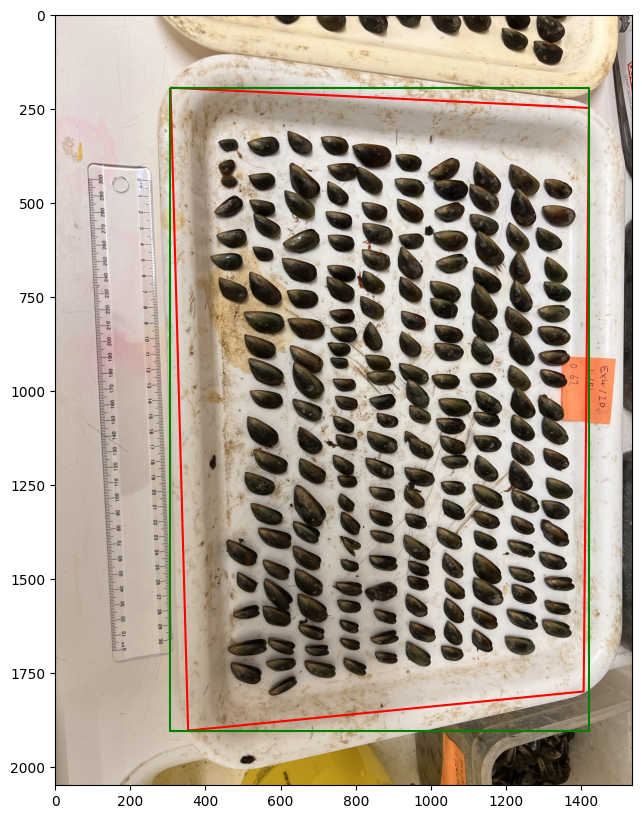

[[ 8.52514856e-01 -3.31867401e-02  4.21931441e+01]
 [-6.01653962e-02  9.10413456e-01  2.97571369e+01]
 [-8.18716445e-05 -2.95251184e-05  1.00000000e+00]]


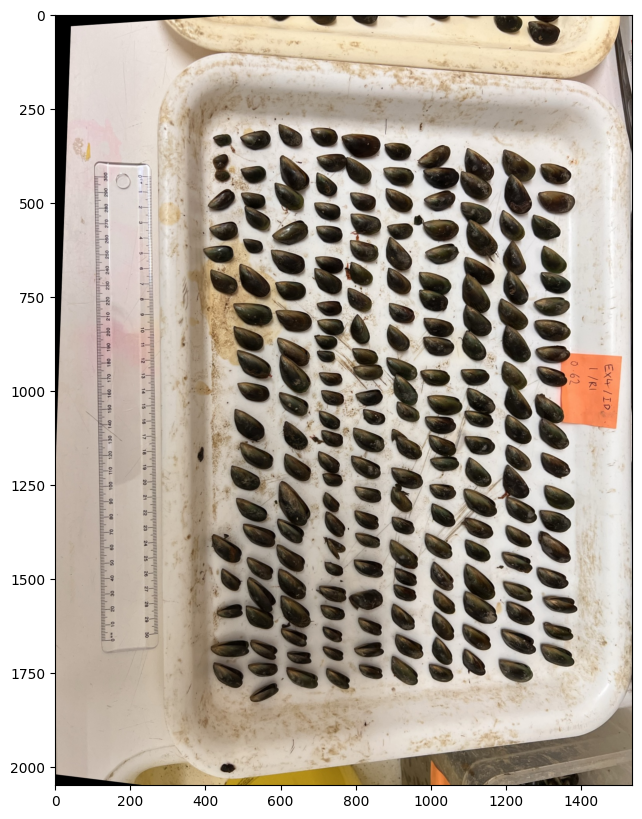

In [3]:
# Reproject trapezoidal tray to rectangular (rectify)
def snap(g1, g2, threshold=1e6):
    coordinates = []
    for x, y in g1.coords:  # for each vertex in the first line
        point = Point(x, y)
        p1, p2 = nearest_points(point, g2)  # find the nearest point on the second line
        if p1.distance(p2) <= threshold:
            # it's within the snapping tolerance, use the snapped vertex
            coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            coordinates.append((x, y))
    # convert coordinates back to a LineString and return
    return LineString(coordinates)

img = cv2.cvtColor(cv2.imread('EX4_ID/D1/IMG_7499.JPEG'), cv2.COLOR_BGR2RGB)
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
tray = max(masks, key=lambda x: x["area"])
# Convert binary mask to polygon
tray = gpd.GeoSeries(shape(s) for s, v in shapes(tray["segmentation"].astype(np.uint8), mask=tray["segmentation"])).unary_union
plt.imshow(img)
trapezoid = snap(tray.envelope.exterior, tray)
bounds = trapezoid.envelope.exterior
gpd.GeoSeries(trapezoid).plot(ax=plt.gca(), color="red")
gpd.GeoSeries(bounds).plot(ax=plt.gca(), color="green")
plt.show()
source_corners = np.float32(trapezoid.coords[:4])
target_corners = np.float32(bounds.coords[:4])
matrix = cv2.getPerspectiveTransform(source_corners, target_corners)
print(matrix)
img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.imshow(img)

In [4]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

287

In [5]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 3255,
 'bbox': [1079, 498, 79, 57],
 'predicted_iou': 1.0125665664672852,
 'point_coords': [[1121.28, 552.96]],
 'stability_score': 0.9628623127937317,
 'crop_box': [0, 0, 1536, 2048]}

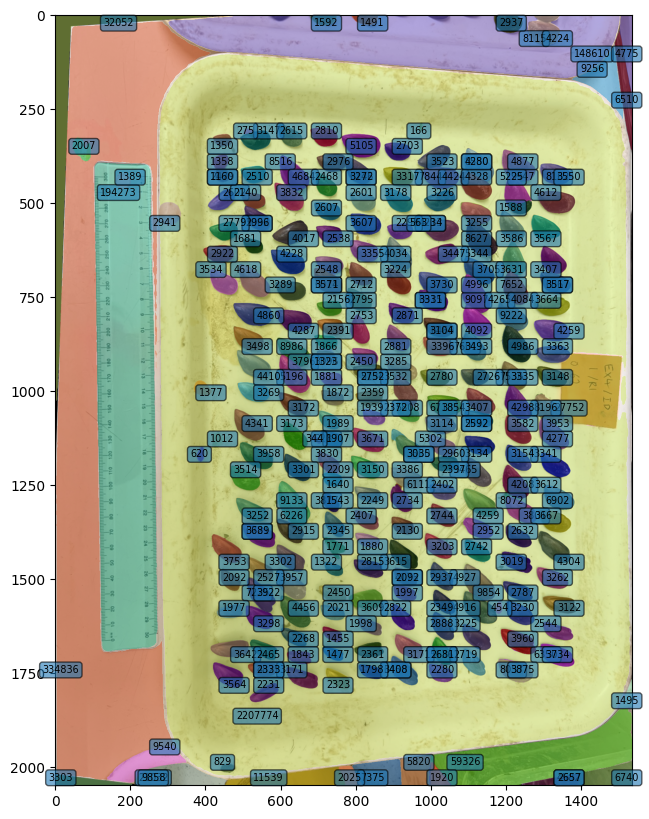

In [6]:
def show_anns(anns, alpha=.5):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
        x, y = ann["point_coords"][0]
        plt.text(s=ann["area"], x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")
    ax.imshow(img)

plt.imshow(img)
show_anns(masks)

In [7]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
full_mask = np.zeros_like(masks[0]["segmentation"]).astype(int)
for i in range(len(masks)):
   x, y = np.where(masks[i]['segmentation'])
   full_mask[x,y] = i + 1

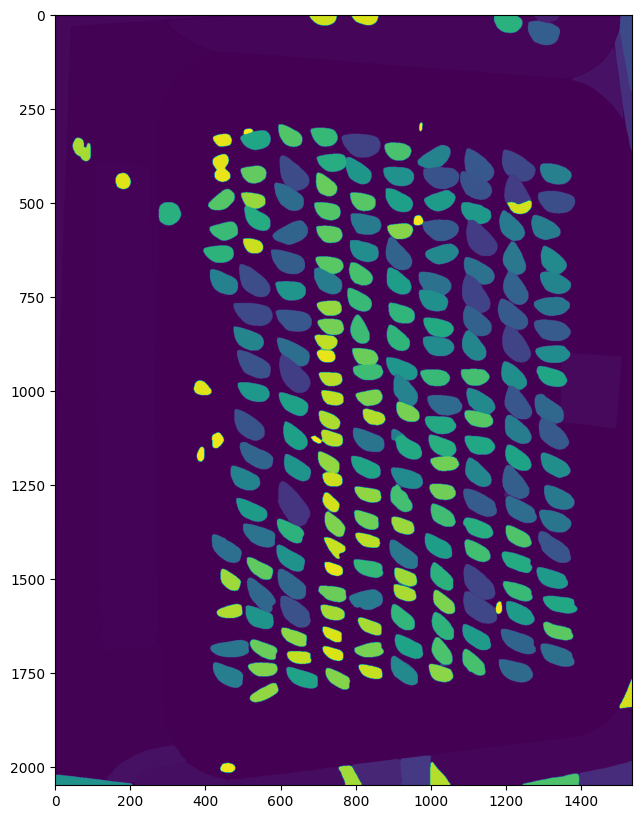

In [8]:
plt.imshow(full_mask)

In [9]:
# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(full_mask.astype(np.uint8), mask=full_mask>0))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))))
df

geometry     id
0     POLYGON ((1268.000 16.000, 1268.000 17.000, 12...   24.0
1     POLYGON ((1263.000 17.000, 1263.000 18.000, 12...   24.0
2     POLYGON ((1260.000 18.000, 1260.000 19.000, 12...   24.0
3     POLYGON ((676.000 0.000, 676.000 3.000, 677.00...   10.0
4     POLYGON ((788.000 0.000, 788.000 3.000, 789.00...   14.0
...                                                 ...    ...
1804  POLYGON ((1529.000 1984.000, 1533.000 1984.000...   36.0
1805  POLYGON ((1050.000 2044.000, 1050.000 2048.000...   70.0
1806  POLYGON ((747.000 1999.000, 756.000 1999.000, ...    9.0
1807  POLYGON ((1242.000 2045.000, 1242.000 2048.000...   70.0
1808  POLYGON ((1377.000 2018.000, 1389.000 2018.000...  207.0

[1809 rows x 2 columns]

<Axes: >

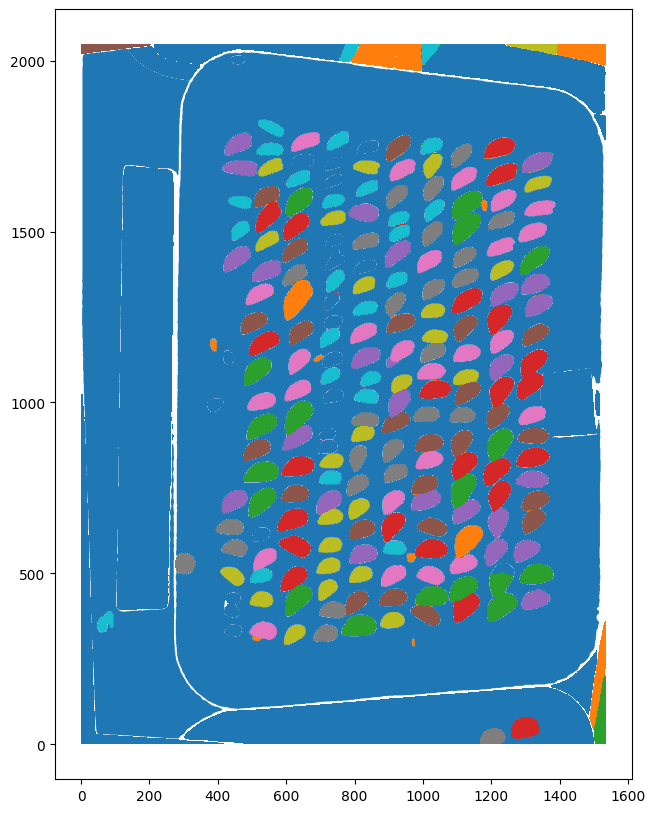

In [10]:
df.plot(column="id", categorical=True)

In [11]:
df["area"] = df.area

<Axes: >

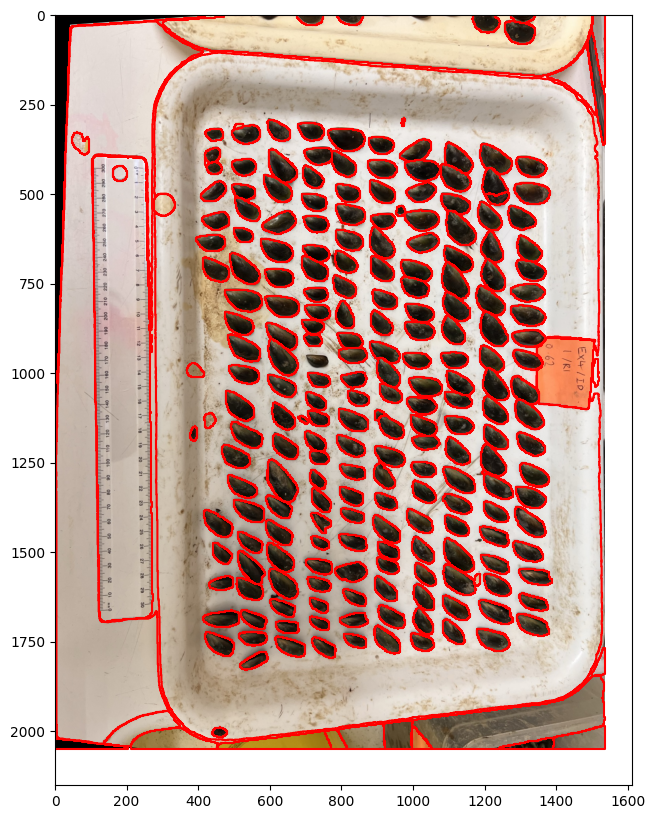

In [12]:
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [13]:
df = df.sort_values(by="area", ascending=False)
df

geometry     id       area
1763  POLYGON ((451.000 104.000, 466.000 104.000, 46...    1.0  1559973.0
1774  POLYGON ((253.000 17.000, 285.000 17.000, 285....    2.0   323712.0
1526  POLYGON ((115.000 392.000, 134.000 392.000, 13...    3.0   192884.0
28    POLYGON ((473.000 0.000, 676.000 0.000, 676.00...    4.0   137249.0
1796  POLYGON ((1514.000 1844.000, 1519.000 1844.000...    5.0    53471.0
...                                                 ...    ...        ...
926   POLYGON ((738.000 1147.000, 738.000 1148.000, ...  236.0        1.0
925   POLYGON ((1315.000 1146.000, 1315.000 1147.000...   22.0        1.0
924   POLYGON ((996.000 1145.000, 996.000 1146.000, ...   51.0        1.0
923   POLYGON ((967.000 1144.000, 967.000 1145.000, ...  124.0        1.0
904   POLYGON ((706.000 1130.000, 706.000 1131.000, ...  236.0        1.0

[1809 rows x 3 columns]

<Axes: >

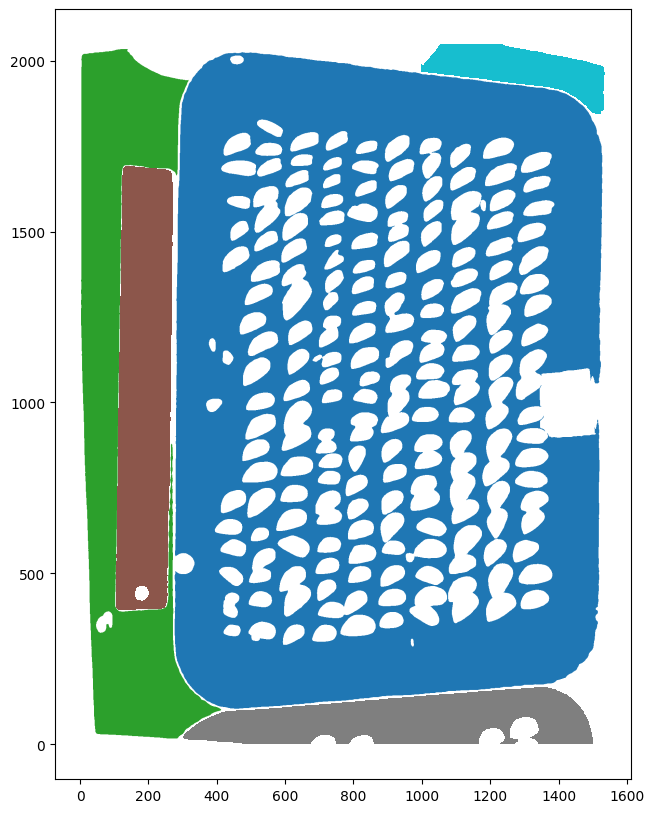

In [14]:
df.head(5).plot(column="id", categorical=True)

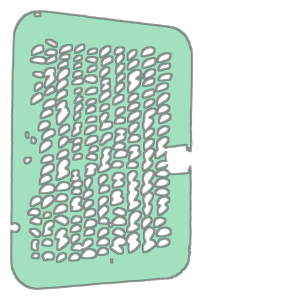

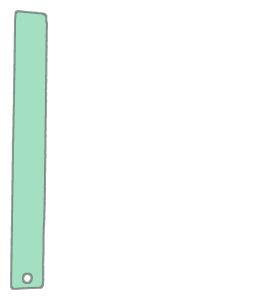

In [15]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
display(tray.geometry)
# The ruler will be one of the top largest objects by area, and it's aspect ratio will be low (width much less than height)
def find_ruler(df):
  for i, row in df.iterrows():
    x1, y1, x2, y2 = row.geometry.bounds
    width = x2 - x1
    height = y2 - y1
    ratio = width / height
    if ratio < .15:
      return row

ruler = find_ruler(df)
display(ruler.geometry)

In [16]:
x1, y1, x2, y2 = ruler.geometry.bounds
ruler_height = y2 - y1
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

40.65625

In [17]:
df["centroid"] = df.centroid

In [18]:
df.iloc[0].centroid.coords[0]

(872.00294780743, 1066.6719004110969)

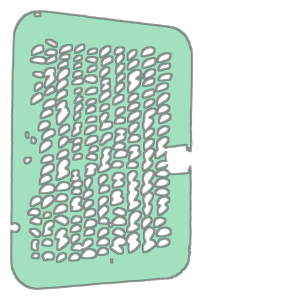

In [19]:
tray.geometry

In [20]:
def get_dimensions(geom):
    x1, y1, x2, y2 = geom.bounds
    width = x2 - x1
    height = y2 - y1
    return width, height

width, height = get_dimensions(tray.geometry)
width, height

(1251.0, 1921.0)

0it [00:00, ?it/s]

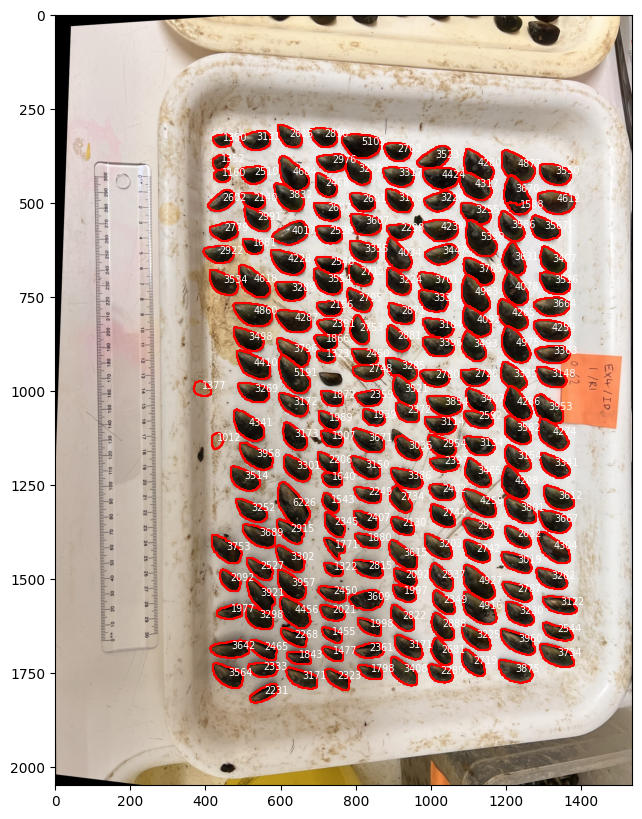

In [21]:
# Filter to just shapes in the tray
tray_edge_buffer = height * .03
area_threshold = height * .5
df = df[df.within(tray.geometry.envelope.buffer(-tray_edge_buffer)) & (df.area > area_threshold)]
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")
for i, row in tqdm(df.iterrows()):
  plt.annotate(round(row.area), row.centroid.coords[0], color="white", fontsize="x-small")

In [22]:
df

geometry    id    area  \
1205  POLYGON ((602.000 1240.000, 607.000 1240.000, ...  43.0  6226.0   
383   POLYGON ((1099.000 545.000, 1100.000 545.000, ...  50.0  5339.0   
742   POLYGON ((604.000 903.000, 605.000 903.000, 60...  53.0  5191.0   
61    POLYGON ((785.000 316.000, 812.000 316.000, 81...  56.0  5105.0   
513   POLYGON ((1096.000 689.000, 1097.000 689.000, ...  58.0  4983.0   
...                                                 ...   ...     ...   
36    POLYGON ((446.000 316.000, 457.000 316.000, 45...  20.0  1350.0   
664   POLYGON ((705.000 891.000, 714.000 891.000, 71...  21.0  1323.0   
1271  POLYGON ((718.000 1455.000, 731.000 1455.000, ...  22.0  1322.0   
180   POLYGON ((444.000 409.000, 452.000 409.000, 45...  23.0  1160.0   
932   POLYGON ((432.000 1110.000, 436.000 1110.000, ...  24.0  1012.0   

                      centroid  
1205  POINT (632.278 1303.750)  
383   POINT (1130.861 597.626)  
742    POINT (634.570 958.930)  
61     POINT (814.817 345.397)  
513   POINT (1116.442 744.022)  
...                        ...  
36     POINT (446.026 332.630)  
664    POINT (721.058 906.984)  
1271  POINT (740.642 1473.601)  
180    POINT (444.836 426.492)  
932   POINT (431.577 1131.035)  

[204 rows x 4 columns]

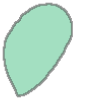

In [23]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

In [24]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for i, a in enumerate(coords):
        for j, b in enumerate(coords):
            if i < j:
                dist = a.distance(b)
                if dist > max_dist:
                    max_dist = dist
                    result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (1205 680, 1243 770)>, 97.6933979345585)

Text(1224.0, 725.0, '97.69px')

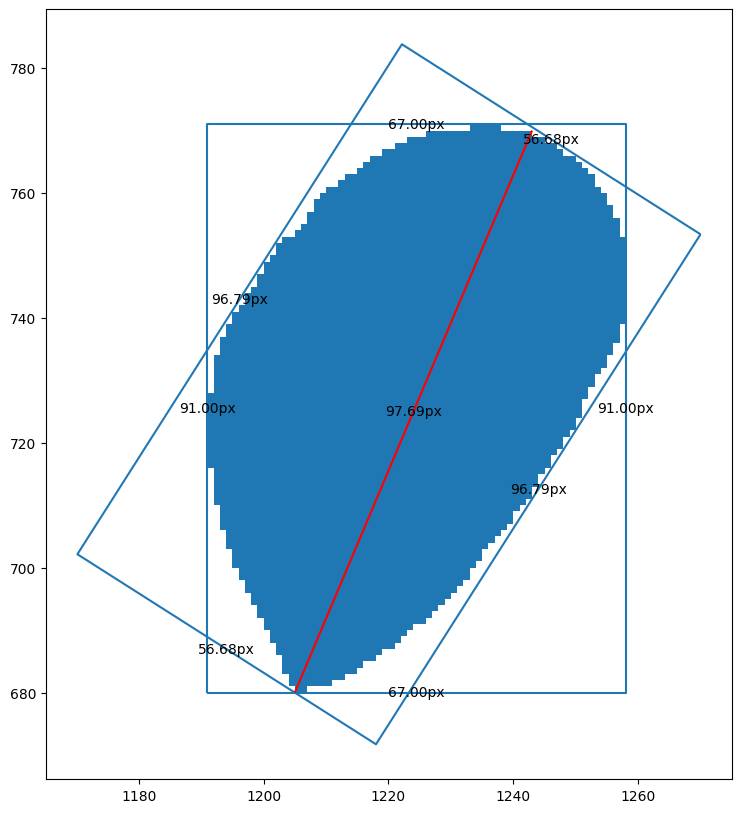

In [25]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = poly.envelope
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [26]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/204 [00:00<?, ?it/s]

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1205    LINESTRING (602.000 1240.000, 663.000 1356.000)
383     LINESTRING (1099.000 545.000, 1168.000 635.000)
742      LINESTRING (667.000 1001.000, 602.000 904.000)
61        LINESTRING (865.000 351.000, 762.000 323.000)
513     LINESTRING (1147.000 788.000, 1093.000 690.000)
                             ...                       
36        LINESTRING (470.000 337.000, 420.000 325.000)
664       LINESTRING (745.000 915.000, 696.000 896.000)
1271    LINESTRING (764.000 1487.000, 716.000 1457.000)
180       LINESTRING (466.000 433.000, 424.000 420.000)
932     LINESTRING (436.000 1110.000, 423.000 1152.000)
Name: diameter_line, Length: 204, dtype: geometry

In [27]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/204 [00:00<?, ?it/s]

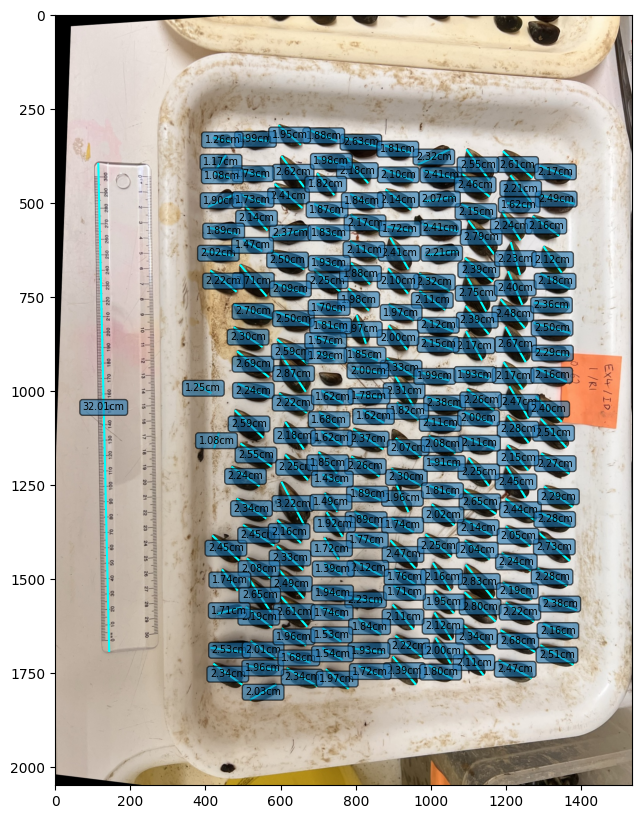

In [28]:
def annotate_length(line):
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.imshow(img)
ax = plt.gca()
gpd.GeoSeries(ruler.diameter_line).plot(color="cyan", ax=ax)
annotate_length(ruler.diameter_line)
df.diameter_line.plot(color="cyan", ax=ax)
for line in tqdm(df.diameter_line):
    annotate_length(line)

In [29]:
df["length_cm"] = df.diameter_line.length / px_per_cm
# Discard results longer than 5cm, probably misdetections
df = df[df["length_cm"] < 5]
df.length_cm.describe()

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


count    204.000000
mean       2.127186
std        0.355273
min        1.081406
25%        1.910739
50%        2.152011
75%        2.370306
max        3.223639
Name: length_cm, dtype: float64